今度は分類問題に対応した NN 実装を考える。  
とはいえ、テンプレは [前回記事](https://white-azalea.hatenablog.jp/entry/2021/03/08/234643) で作ってるので、さっくりテンプレぽくまずは定義する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

wb_width = 0.01 # 重みバイアスの広がり方
epoch    = 101  # 学習データ数
eta      = 0.1  # 学習係数

# 各層のニューロン数
n_in  = 2
n_mid = 6
n_out = 2

class Neuron:
    def __init__(self, n_upper, n, activation_function, differential_function):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        self.grad_w = np.zeros((n_upper, n))
        self.grad_b = np.zeros((n))
        self.activation_function = activation_function
        self.differential_function = differential_function

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
    def forward(self, x):
        self.x = x
        u = x.dot(self.w) + self.b
        self.y = self.activation_function(u)
        return self.y

    def backword(self, t):
        delta = self.differential_function(self.y, t)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x
    
    def show(self):
        print(json.dumps(self.w.tolist()))
        print(json.dumps(self.b.tolist()))


class Output(Neuron):
    pass


class Middle(Neuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x

判定の場合、出力層が異なってくる

* 中間層活性関数: シグモイド関数
* 出力層活性関数: ソフトマックス関数
* 損失関数: 交差エントロピー誤差
* 最適化関数: 確率的勾配降下法

シグモイド関数はこんな式なので

$$
f(x) = \frac{1}{1 + e^{-x}} \\
\delta_j = \partial y_j (1 - y_j)y_j
$$

In [2]:
def sigmoid(u):
    """シグモイド関数"""
    return 1 / (1 + np.exp(-u))


def differential_sigmod(grad_y, y):
    """シグモイド関数の勾配関数"""
    return grad_y * (1 - y) * y

出力層のソフトマックス関数 + 交差エントロピーは [過去計算](https://white-azalea.hatenablog.jp/entry/2021/03/07/200147) した式を拝借して

$$
E(t,y) = - \sum_x t_x log(y_x) ... 交差エントロピー誤差  \\
y = \frac{exp(x)}{\sum^n_{k=1} exp(k)} .. ソフトマックス関数
$$

$$
E = - \sum_k t_k log( \frac{exp(u_k)}{ \sum_k exp(u_k) } ) \\
\delta_k = -t_k + y_k
$$

In [3]:
def soft_max(u):
    """ ソフトマックス関数 """
    return np.exp(u) / np.sum(np.exp(u), axis = 1, keepdims=True)


def differential_softmax(y, t):
    """ソフトマックス + 交差エントロピー の勾配関数"""
    return y - t

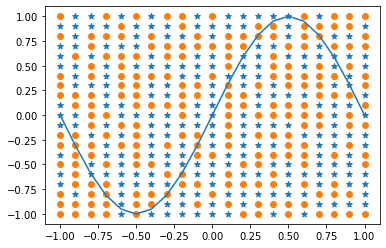

Epoch:0 / Error: 0.7260764044359691


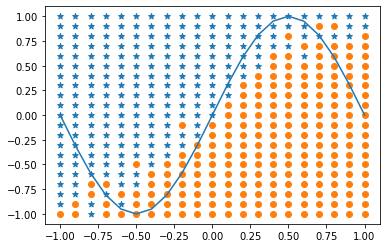

Epoch:10 / Error: 0.35183712181134624


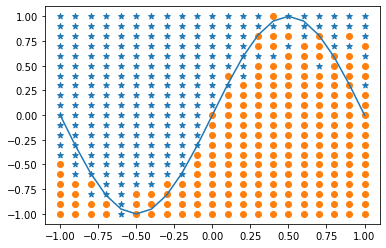

Epoch:20 / Error: 0.23131478815551249


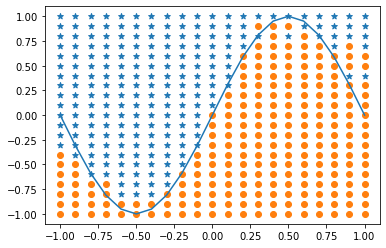

Epoch:30 / Error: 0.1779948347753419


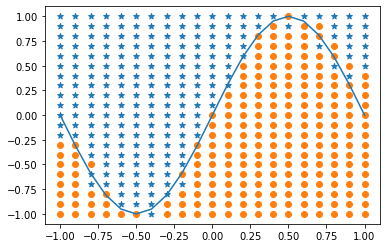

Epoch:40 / Error: 0.1374592584620364


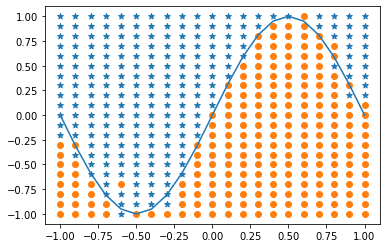

Epoch:50 / Error: 0.10926446347323222


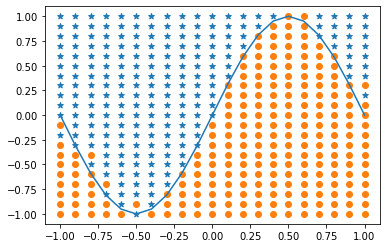

Epoch:60 / Error: 0.08261516860647307


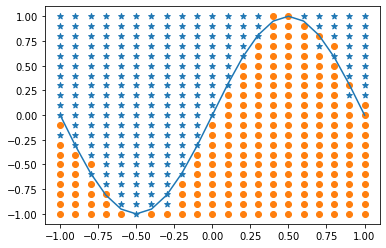

Epoch:70 / Error: 0.08133738573767374


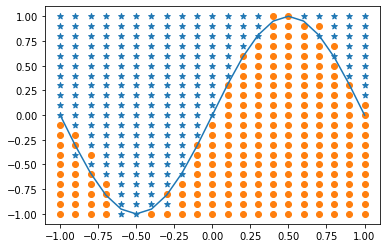

Epoch:80 / Error: 0.07725574345664493


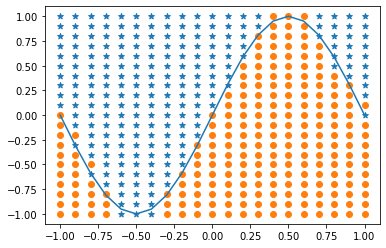

Epoch:90 / Error: 0.07407594540278198


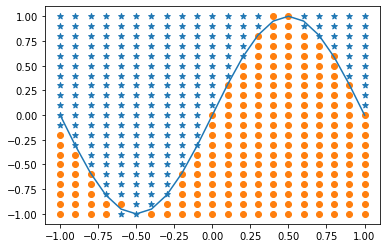

Epoch:100 / Error: 0.06332837115170598


In [4]:
# 座標系
X = np.arange(-1.0, 1.1, 0.1)
Y = np.arange(-1.0, 1.1, 0.1)

# 学習データ
input_data   = []
correct_data = []
for x in X:
    for y in Y:
        input_data.append([x, y])
        if y < np.sin(np.pi * x):
            correct_data.append([0, 1])
        else:
            correct_data.append([1, 0])

n_data       = len(correct_data)
input_data   = np.array(input_data)
correct_data = np.array(correct_data)


# ニューロン生成
middle = Middle(n_in, n_mid, sigmoid, differential_sigmod)
output = Output(n_mid, n_out, soft_max, differential_softmax)

# 中間出力
interval = 10

# 表示用
sin_data = np.sin(np.pi * X)

for i in range(epoch):
    # ランダムなインデックス値生成
    rand_idx = np.arange(n_data)
    np.random.shuffle(rand_idx)

    # 中間結果表示用データ
    total_err = 0
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []

    for idx in rand_idx:
        # テストデータと、教師データ
        x = input_data[idx]
        t = correct_data[idx]

        # 順伝播
        y = output.forward(middle.forward(x.reshape(1, 2)))

        # 逆伝播
        middle.backword(output.backword(t.reshape(1, 2)))

        # 学習
        middle.update(eta)
        output.update(eta)

        if i % interval == 0:
            y = output.y.reshape(-1)
            total_err += - np.sum(t * np.log(y + 1e-7))

            if y[0] > y[1]:
                x_1.append(x[0])
                y_1.append(x[1])
            else:
                x_2.append(x[0])
                y_2.append(x[1])

    if i % interval == 0:
        plt.plot(X, sin_data)
        plt.scatter(x_1, y_1, marker='*')
        plt.scatter(x_2, y_2, marker='o')
        plt.show()
        print(f"Epoch:{i} / Error: {total_err/n_data}")

In [5]:
output.forward(middle.forward(np.array([[0.25, 0.5]])))

array([[0.00640773, 0.99359227]])

In [6]:
output.forward(middle.forward(np.array([[1, 0.4]])))

array([[0.98752717, 0.01247283]])

In [7]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=0)

In [8]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

X_train.head()

,0,1,2,3
0,5.9,3.0,4.2,1.5
1,5.8,2.6,4.0,1.2
2,6.8,3.0,5.5,2.1
3,4.7,3.2,1.3,0.2
4,6.9,3.1,5.1,2.3


In [9]:
y_train.head()

,0
0,1
1,1
2,2
3,0
4,2


In [10]:


def conv(x):
    if x == 0:
        return np.array([1, 0, 0])
    elif x == 1:
        return np.array([0, 1, 0])
    else:
        return np.array([0, 0, 1])

y_train[0] = y_train[0].apply(conv)
y_test[0] = y_test[0].apply(conv)
y_train.head()

,0
0,"[0, 1, 0]"
1,"[0, 1, 0]"
2,"[0, 0, 1]"
3,"[1, 0, 0]"
4,"[0, 0, 1]"


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       112 non-null    float64
 1   1       112 non-null    float64
 2   2       112 non-null    float64
 3   3       112 non-null    float64
dtypes: float64(4)
memory usage: 3.6 KB


In [12]:
X_train = X_train.applymap(lambda x: x / 10.0)
X_test = X_test.applymap(lambda x: x / 10.0)
X_train.head()

,0,1,2,3
0,0.59,0.30,0.42,0.15
1,0.58,0.26,0.40,0.12
2,0.68,0.30,0.55,0.21
3,0.47,0.32,0.13,0.02
4,0.69,0.31,0.51,0.23


In [13]:
wb_width = 0.01 # 重みバイアスの広がり方
epoch    = 101  # 学習データ数
eta      = 0.1  # 学習係数

# 各層のニューロン数
n_in  = 4
n_mid = 8
n_out = 3

# 学習データ
input_data   = np.array(X_train.values)
correct_data = np.array(y_train.values)
n_data = len(correct_data)


In [14]:
middle = Middle(n_in, n_mid, sigmoid, differential_sigmod)
output = Output(n_mid, n_out, soft_max, differential_softmax)

for i in range(epoch):
    # ランダムなインデックス値生成
    rand_idx = np.arange(n_data)
    np.random.shuffle(rand_idx)

    # 中間結果表示用データ
    total_err = 0
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []

    for idx in rand_idx:
        # テストデータと、教師データ
        x = input_data[idx]
        t = correct_data[idx][0]

        # 順伝播
        y = output.forward(middle.forward(x.reshape(1, 4)))

        # 逆伝播
        middle.backword(output.backword(np.array(t)))

        # 学習
        middle.update(eta)
        output.update(eta)

        if i % interval == 0:
            total_err += - np.sum(t * np.log(y + 1e-7))
    if i % interval == 0:
        print(f"Epoch:{i} / Error: {total_err/n_data}")

Epoch:0 / Error: 1.143620666782127
Epoch:10 / Error: 1.099176194815201
Epoch:20 / Error: 0.6723668184372019
Epoch:30 / Error: 0.4080012397216436
Epoch:40 / Error: 0.3019479069646089
Epoch:50 / Error: 0.22877615533860077
Epoch:60 / Error: 0.1881199469654864
Epoch:70 / Error: 0.1722913635957264
Epoch:80 / Error: 0.14976146034202345
Epoch:90 / Error: 0.12888274356090335
Epoch:100 / Error: 0.10493448551076304


学習済みニューラルネットワークに検証用データを食わせて結果を見る

In [15]:
input_data   = np.array(X_test.values)
correct_data = np.array(y_test.values)


def is_match(y, t):
    """[a, b, c] から最も大きい値を 1 として考える"""
    a, b, c = t
    if a > b and a > c:
        return t[0] == 1
    elif b > a and b > c:
        return t[1] == 1
    else:
        return t[2] == 1

correct_count = 0
for idx in range(len(X_test)):
    x = input_data[idx]
    t = correct_data[idx][0]

    # 順伝播してみる
    y = output.forward(middle.forward(x.reshape(1, 4)))
    y = y.reshape(-1)
    
    # 結果比較
    if is_match(y, t):
        correct_count += 1

print(f'Correct rate: {correct_count} / {len(X_test)}')

Correct rate: 38 / 38


In [16]:
middle.show()
output.show()

[[0.13600163175388186, -0.28640599622674745, -0.3198595985999736, 0.6748627436776083, -0.6767040757122191, 0.2862555778783913, 0.2161914828693007, 0.20334538810094638], [-0.3267865527879121, 0.962820987647634, 0.8578509492996487, 2.5375212464911945, -0.17565998263357885, 2.0569966567312554, -0.3767961628049838, 1.969739583609608], [1.1174827258921367, -3.76856251191964, -3.5267295594952928, -8.072345742759193, -1.2889460843851426, -6.883178452355738, 1.4973878109312184, -6.6163819817908704], [0.5680865245422342, -2.038091706811952, -1.8693828542509907, -4.778954378732017, -0.6464604247151088, -3.995638758951651, 0.7633294482838691, -3.8045469489854624]]
[0.1726014261541222, 0.9250082298911458, 0.7991602819536568, 2.850870793467469, -0.6637739979817499, 2.3176331433728516, 0.23020471041862656, 2.1813227439740346]
[[-1.9878775661542982, 0.35823187694337266, 1.609139984690025], [2.526609858028673, 0.20175791461110695, -2.7600431957935943], [2.3267465826823464, 0.19893621840632658, -2.5208

In [17]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.loc[df['target'] == 0, 'target'] = "setosa"
df.loc[df['target'] == 1, 'target'] = "versicolor"
df.loc[df['target'] == 2, 'target'] = "virginica"
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
